In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from tqdm.notebook import tqdm

from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter
import qiskit.quantum_info as qi

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# 밀접 결합(Tight-binding) 모델

<div>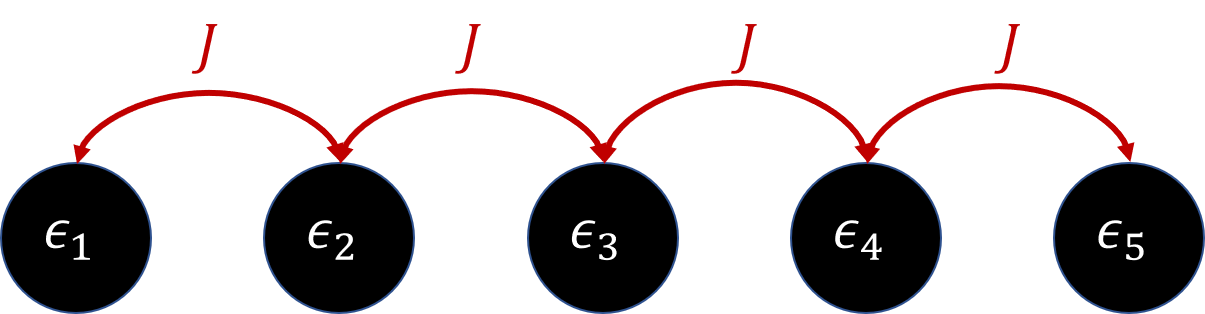</div>

밀접결합 모델은 고체 상태 물질의 전자의 전도율을 양자 역학적으로 묘사하기 위해 사용됩니다.  이 모델에서 각 원자는 격자 위치(lattice site)로 다뤄지고, 입자는 그 자리를 차지하기 위해 에너지 $\epsilon_i$를 필요로 합니다. 전자는 $J$의 에너지 비용으로 인접 위치로 터널링할 수 있습니다. 이 모델은 다음 해밀토니안으로 표현됩니다.

$$H_{\rm tb}/\hbar = \sum_i \epsilon_i Z_i + J \sum_{\langle i,j \rangle} (X_i X_j + Y_i Y_j)$$

해밀토니언의 첫 번째 항은 각 위치의 제자리(on-site) 에너지를 설명하고 두 번째 항은 인접 격자 위치 간의 상호 작용 에너지를 설명합니다. 주기적 격자 퍼텐셜이 있는 경우, 주어진 양자 입자의 파동 함수는 인접한 격자 위치와 중첩되어 확장된 블로흐(Bloch) 파동 함수로 이어집니다. 모든 위치의 에너지가 동일한($\epsilon_i=0$) 균일한 격자에서 전자 전파는 시간에 따라 선형이며 연속 시간 양자 랜덤 워크(Continuous-time quantum random walk)로 설명됩니다. 이것은 전파가 시간적에 대하여 2차적(quadratically)으로 느린 고전적인 확산 수송과 대조됩니다.

양자 상태가 시간에 따라 어떻게 변화하는지는 시스템 해밀토니언을 통해 결정할 수 있으며 이 시간적 변화(time evolution)는 슈뢰딩거 방정식에 의해 결정됩니다.

$$ i \hbar \frac{\partial}{\partial t}|\psi(t)\rangle = H |\psi(t)\rangle $$

시간 독립적 해밀토니언(시간에 따라 변하지 않는 해밀토니안)의 경우 슈뢰딩거 방정식의 해는 다음과 같은 형식이 됩니다.

$$ |\psi(t)\rangle = e^{-i H t / \hbar} |\psi(0)\rangle $$

이 연습에서는  밀접 결합 해밀토니언의 시간에 따른 역학을 배우고, 시간적 변화를 위한 Trotterized 회로를 구성합니다.

## 1. 밀접 결합 해밀토니언의 시간적 변화

먼저 3개의 격자 위치가 있는 밀접 결합 해밀토니언의 시간적 변화를 생각해 보겠습니다. 균일한 격자로 다루기 위해 $J=1$ 및 $\epsilon_i=0$로 설정합니다.

In [ ]:
# Import Pauli operators (I, X, Y, Z)
from qiskit.opflow import I, X, Y, Z

J = 1

# tight-binding Hamiltonian
def H_tb():
    # Interactions (I is the identity matrix; X and Y are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    
    # Sum interactions
    H = J*(XXs + YYs)
    
    # Return Hamiltonian
    return H

In [ ]:
# Unitary evolution under the tight-binding Hamiltonian
def U_tb(t):
    H = H_tb()
    return (t * H).exp_i()

시스템 상태를 $|100\rangle$로 초기화하고 $|100\rangle, |010\rangle, |001\rangle$ 상태의 확률을 확인해봅니다. 이 값은 격자의 서로 다른 위치에서 입자를 찾을 확률에 해당합니다.

In [ ]:
# Import qubit states Zero (|0>) and One (|1>)
from qiskit.opflow import Zero, One

# Define array of time points
ts = np.linspace(0, 3, 100) # DO NOT CHANGE THIS

initial_state=One^Zero^Zero

state_t=[U_tb(float(t)) @ initial_state for t in ts]

p_100= [np.abs( (~(One^Zero^Zero) @ state).eval() )**2 for state in state_t]
p_010= [np.abs( (~(Zero^One^Zero) @ state).eval() )**2 for state in state_t]
p_001= [np.abs( (~(Zero^Zero^One) @ state).eval() )**2 for state in state_t]

plt.figure(facecolor='white')
plt.plot(ts, p_100, label=r'$p_{100}$')
plt.plot(ts, p_010, label=r'$p_{010}$')
plt.plot(ts, p_001, label=r'$p_{001}$')
plt.xlabel(r'Time (1/J)')
plt.ylabel(r'Population')
plt.legend()
pass

## 2. Trotterization

[회로 모델](https://qiskit.org/documentation/apidoc/circuit.html) 양자 컴퓨터에서 유니테리 시간적 변화를 실행하려면 $U_{\text{tb}}(t)$를 양자 컴퓨터 고유의 단일 및 2큐비트 게이트의 조합으로  분해해야 합니다. 회로를 분해하는 여러가지 방법 중 한 가지 방법은 Trotter-Suzuki 분해라고도 하는[Trotterization](https://en.wikipedia.org/wiki/Hamiltonian_simulation#Product_Formulas) 입니다.

아래에서 [1-2]에 설명된 것과 같은 Trotterization의 예제를 확인해 봅시다.

[Pauli 연산자는 서로 교환 가능(commute)하지 않으므로](https://en.wikipedia.org/wiki/Pauli_matrices#Commutation_relations) 지수 $U_{\text{tb}}(t)$는 더 간단한 형태의 지수의 곱으로 쪼갤 수 없습니다. 그러나 Trotterization을 통해 $U_{\text{tb}}(t)$를 더 간단한 지수의 곱으로 근사할 수 있습니다. 스핀 세 개로 구성된 시스템에서 두 개의 스핀-1/2 입자로 구성된 부분계(subsystem)를 생각해 봅시다. 스핀 $i$ 및 $j$($i,j \in {0,1,2}$)의 해밀토니언은 $H^{(i,j)}_{\text{tb}} = \sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}$ 입니다. 시뮬레이션하고자 하는 총 $N=3$ 시스템 내의 두 개의 가능한 부분계의 관점에서 $U_{\text{tb}}(t)$를 다시 써봅시다.

$$ U_{\text{tb}}(t) = \exp\left[-it \left(H^{(0,1)}_{\text{tb}} + H^{(1,2)}_{\text{tb}} \right)\right]. $$

$H^{(0,1)}_{\text{tb}}$와 $H^{(1,2)}_{\text{tb}}$는 서로 교환가능 하지 않으므로 $U_{\text{tb} }(t) \neq \exp\left(-it H^{(0,1)}_{\text{tb}}\right) \exp\left(-it H^{(1,2)}_{\text{tb}} \right)$입니다. 그러나 이 곱 분해(product decomposition)는 Trotterization에 의해 $U_{\text{tb}}(t)$가 근사적으로 $H^{(0,1)}_{\text{tb}}$ ( time = $t/n$)의 짧은 시간적 변화(short evolution)와 그에 뒤따르는  $n$번 반복되는 $H^{(1,2)}_{\text{tb}}$ (time = $t/n$)의 짧은 시간적 변화로 근사될수 있음을 보여줍니다.

$$
\begin{align}
U_{\text{tb}}(t) &= \exp\left[-i t \left(H^{(0,1)}_{\text{tb}} + H^{(1,2)}_{\text{tb}} \right)\right] \\
U_{\text{tb}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}H^{(0,1)}_{\text{tb}}\right) \exp\left(\dfrac{-it}{n}H^{(1,2)}_{\text{tb}} \right)\right]^n.
\end{align}
$$

$n$은 Trotter 단계 수이며 $n$이 증가할수록 근사치가 더 정확해집니다. (유니테리가 Trotterization 과정에서 부분계로 분할되는 방식은 반드시 고유한 것은 아님을 기억하십시오). 분해를 더 진행합니다. 2개의 각각의 스핀 부분계 내에서, Pauli 연산자 쌍($\sigma_x^{(i)}\sigma_x^{(j)}$, $\sigma_y^{(i)}\sigma_y^{(j)}$ 및 $\sigma_z^{(i)}\sigma_z^{(j)}$) 는 서로 교환 가능합니다. 이는 부분계 해밀토니언의 지수 ($H^{(i,j)}_{\text{tb}}$)를 더욱 간단한 지수의 곱으로 쪼갤수 있음을 의미하며 이를 통해 $U_{\text{tb}}(t)$의 게이트 구현에 한발 더 가까워질수 있음을 의미합니다.


$$
\begin{align}
U_{\text{tb}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}H^{(0,1)}_{\text{tb}}\right) \exp\left(\dfrac{-it}{n}H^{(1,2)}_{\text{tb}} \right)\right]^n \\
U_{\text{tb}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}\left(\sigma_x^{(0)}\sigma_x^{(1)} + \sigma_y^{(0)}\sigma_y^{(1)} \right)\right) \exp\left(\dfrac{-it}{n}\left(\sigma_x^{(1)}\sigma_x^{(2)} + \sigma_y^{(1)}\sigma_y^{(2)} \right)\right)\right]^{n} \\
U_{\text{tb}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}\sigma_x^{(0)}\sigma_x^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_y^{(0)}\sigma_y^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_x^{(1)}\sigma_x^{(2)}\right) \exp\left(\dfrac{-it}{n}\sigma_y^{(1)}\sigma_y^{(2)}\right) \right]^{n}
\end{align}
$$

식을 더 단순하게 만들고, 일반적으로 많이 사용하는 표기법을 사용하기 위해서, $XX(2t) = \exp\left(-it \sigma_x\sigma_x\right)$ 와 $YY(2t) = \exp\left(-it \sigma_y\sigma_y\right)$ 로 곱의 항의 이름을 바꾸고, 이를 위의 Trotterized $U_{\text{tb}}(t)$에 대입하여 정리할 수 있습니다.

$$
U_{\text{tb}}(t) \approx \left[XX\left(\frac{2t}{n}\right)^{(0,1)} YY\left(\frac{2t}{n}\right)^{(0,1)}  XX\left(\frac{2t}{n}\right)^{(1,2)} YY\left(\frac{2t}{n}\right)^{(1,2)}\right]^{n}
$$

이제 $U_{\text{tb}}(t)$를 $XX(t)$ 및 $YY(t)$의 2-큐비트 게이트로 대략적으로 분해하는데 성공했습니다. 이 게이트들은 초전도 큐비트의 고유 게이트는 아니만, 초전도 큐비트의 고유 단일 및 2-큐비트 게이트로 분해될 수 있습니다. 이에 대한 내용은 섹션 2의 *추가 자료에서 더 자세한 내용을 확인할 수 있습니다.* 

[1] Y. Salathe, et al., *Digital Quantum Simulation of Spin Models with Circuit Quantum Electrodynamics*, [Phys. Rev. X **5**, 021027 (2015)](https://link.aps.org/doi/10.1103/PhysRevX.5.021027)

[2] F. Tacchino, et al., *Quantum Computers as Universal Quantum Simulators: State-of-the-Art and Perspectives*, [Adv. Quantum Technol. *3* 3 (2020)](https://doi.org/10.1002/qute.201900052) [[free arxiv version](https://arxiv.org/abs/1907.03505)]


### 2.1 개별 Pauli 유니테리들의 구성

이 섹션에서는 단일 및 2-큐비트 게이트를 사용하여 ZZ(t), XX(t) 및 YY(t) 연산을 작성해 보겠습니다.

In [ ]:
t = Parameter('t')

In [ ]:
# Build a subcircuit for ZZ(t) from single- and two-qubit gates

ZZ_qr = QuantumRegister(2)
ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ')

ZZ_qc.cnot(0,1)
ZZ_qc.rz(2 * t, 1)
ZZ_qc.cnot(0,1)

# Convert custom quantum circuit into a gate
ZZ = ZZ_qc.to_instruction()

ZZ_qc.draw()

### 2.2 Clifford 게이트

Clifford 게이트는 Pauli 연산자를 다른 Pauli 연산자에 매핑(사상)하는 양자 연산자입니다. Hadamard 게이트($H$)와 위상 게이트($S$)는 단일 큐비트 Clifford 게이트의 예시입니다.

$$H=\frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1 \\1 & -1\\ \end{pmatrix}$$

$HZH^\dagger=X$, 및 $HXH^\dagger=Z$ 입니다. Hadamard 게이트는 에르미트(Hermitian) 연산자이므로 $H=H^\dagger$입니다.

$$S=\begin{pmatrix} 1 & 0 \\0 & i\\ \end{pmatrix}$$

$SXS^\dagger=Y$이고 $SYS^\dagger=-X$입니다.

Clifford 게이트를 사용하여 $e^{i ZZ t}$를 $e^{i XX t}$ 및 $e^{i YY t}$로 변환할 수 있습니다.

<div class="alert alert-block alert-danger">

<b>도전 질문 1a</b>
단일 및 2-큐비트 게이트로 XX(t)의 부분 회로(subcircuit)를 구성해 봅시다.
</div>

In [ ]:

XX_qr = QuantumRegister(2)
XX_qc = QuantumCircuit(XX_qr, name='XX')

###EDIT CODE BELOW (add Clifford operator)

###DO NOT EDIT BELOW

XX_qc.append(ZZ, [0,1])

###EDIT CODE BELOW (add Clifford operator)

###DO NOT EDIT BELOW

# Convert custom quantum circuit into a gate
XX = XX_qc.to_instruction()

XX_qc.draw()

In [ ]:
## Grade and submit your solution
from qc_grader.challenges.spring_2022 import grade_ex1a

grade_ex1a(XX_qc)


<div class="alert alert-block alert-danger">

<b>도전 질문 1b</b>
단일 및 2-큐비트 게이트로 YY(t)의 부분 회로를 구성해 봅시다.
</div>

In [ ]:

YY_qr = QuantumRegister(2)
YY_qc = QuantumCircuit(YY_qr, name='YY')

###EDIT CODE BELOW (add Clifford operator)


###DO NOT EDIT BELOW

YY_qc.append(ZZ, [0,1])

###EDIT CODE BELOW (add Clifford operator)


###DO NOT EDIT BELOW

# Convert custom quantum circuit into a gate
YY = YY_qc.to_instruction()

YY_qc.draw()

In [ ]:
## Grade and submit your solution
from qc_grader.challenges.spring_2022 import grade_ex1b

grade_ex1b(YY_qc)


### 2.3 Trotterized 회로 구성

$X_iX_j$ 및 $Y_iY_j$ 연산자는 서로 교환가능(commute)합니다:

$$[X_iX_j, Y_iY_j]= X_iX_j.Y_iY_j - Y_iY_j.X_iX_j = Z_iZ_j-(-Z_i)(-Z_j)=0$$.

따라서 $e^{it (X_iX_j + Y_iY_j)}$를 $e^{it X_iX_j} e^{it Y_iY_j}$로 분해할 수 있습니다. 또한 $i\neq j \neq k \neq l$이면 $[X_iX_j,X_kX_l]=0$입니다. 이를 기반으로 각 trotterized 변화의 시간 단계를 두 블록으로 나눌 수 있습니다:

$$U(\Delta t) \approx \Big(\prod_{i \in \rm{odd}} e^{-i \Delta t X_iX_{i+1}} e^{-i \Delta t Y_iY_{i+1}} \Big) \Big(\prod_{i \in \rm{even}} e^{-i \Delta t X_iX_{i+1}} e^{-i \Delta t Y_iY_{i+1}} \Big)$$

In [ ]:
num_qubits = 3

Trot_qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

for i in range(0, num_qubits - 1):
    Trot_qc.append(YY, [Trot_qr[i], Trot_qr[i+1]])
    Trot_qc.append(XX, [Trot_qr[i], Trot_qr[i+1]])

# Convert custom quantum circuit into a gate
Trot_gate = Trot_qc.to_instruction()

Trot_qc.draw()

<div class="alert alert-block alert-danger">

<b>도전 질문 1c</b>
trotterized 회로를 생성하고 회로와 관련된 유니테리를 출력해 봅시다.
</div>

In [ ]:

def U_trotterize(t_target, trotter_steps):
    qr = QuantumRegister(3)
    qc = QuantumCircuit(qr)

    ###EDIT CODE BELOW (Create the trotterized circuit with various number of trotter steps)

    
    ###DO NOT EDIT BELOW
        
    qc = qc.bind_parameters({t: t_target/trotter_steps})
    
    return qi.Operator(qc)

In [ ]:
t_target = 0.5
U_target = U_tb(t_target)

steps=np.arange(1,101,2)  ## DO NOT EDIT

fidelities=[]
for n in tqdm(steps):
    U_trotter = U_trotterize(t_target, trotter_steps=n)
    fidelity = qi.process_fidelity(U_trotter, target=U_target)
    fidelities.append(fidelity)

plt.figure(facecolor='white')
plt.loglog(steps, 1-np.array(fidelities))
plt.ylabel('Trotter error')
plt.xlabel('Trotter steps')

In [ ]:
## Grade and submit your solution
from qc_grader.challenges.spring_2022 import grade_ex1c

grade_ex1c(fidelities)


## 추가 정보

**한글화:** 김경훈, 신소영